In [7]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from transformers import BertTokenizer, BertConfig
from transformers.modeling_outputs import SequenceClassifierOutput
from transformers import BertPreTrainedModel, BertModel
from tqdm import tqdm
import os
import safetensors.torch as st
import matplotlib.pyplot as plt

In [2]:
# Model definition (copied from main.py)
class SmallerBERTClassifier(BertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.bert = BertModel(config)
        self.dropout = nn.Dropout(0.4)
        self.classifier = nn.Sequential(
            nn.Linear(config.hidden_size, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, config.num_labels)
        )

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        pooled = self.dropout(outputs.pooler_output)
        logits = self.classifier(pooled)
        return SequenceClassifierOutput(
            loss=None,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions
        )

# Paths
MODEL_DIR = "saved_liar_bert_model"
WEIGHTS_PATH = os.path.join(MODEL_DIR, "model.safetensors")
TSV_PATH = "../../LIAR-PLUS-master/dataset/tsv/train2.tsv"
OUTPUT_CSV = "train2_preds.csv"

# Load tokenizer and model
tokenizer = BertTokenizer.from_pretrained(MODEL_DIR)
config = BertConfig.from_pretrained(MODEL_DIR)
model = SmallerBERTClassifier(config)

# Load weights from safetensors
state_dict = st.load_file(WEIGHTS_PATH)
model.load_state_dict(state_dict)
model.eval()

SmallerBERTClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, ele

In [105]:
import numpy as np

statement = "When Obama was sworn into office, he DID NOT use the Holy Bible, but instead the Kuran (Their equivalency to our Bible, but very different beliefs)."
justification = "Ellison used a Koran that once belonged to Thomas Jefferson, borrowing the rare book from the Library of Congress. It goes without saying that Ellison is not Obama. UPDATE:  Barack Obama  resigned from Trinity United Church of Christ  on May 31, 2008, after church pastor Jeremiah A.  Wright Jr.  made controversial remarks about U. S.  foreign policy and other matters."

# Ensure both are strings and handle NaN
if not isinstance(statement, str):
    statement = "" if pd.isna(statement) else str(statement)
if not isinstance(justification, str):
    justification = "" if pd.isna(justification) else str(justification)

# Tokenize as in main.py
inputs = tokenizer(
    statement,
    justification,
    return_tensors="pt",
    truncation=True,
    padding=True,
    max_length=256
)

with torch.no_grad():
    outputs = model(**inputs)
    probs = torch.softmax(outputs.logits, dim=1).squeeze()
    prediction = torch.argmax(probs).item()
    confidence = probs[prediction].item()

print(prediction, confidence)

0 0.5125752687454224


In [3]:
df_val = pd.read_csv("val2_preds.csv")
df_train = pd.read_csv("train2_preds.csv")
df_test = pd.read_csv("test2_preds.csv")

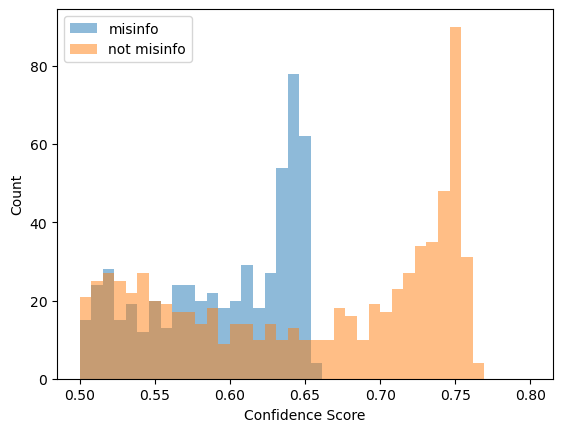

In [8]:
plt.hist(df_val["confidence_score"][df_val["prediction"] == "misinfo"], bins=np.linspace(0.5, 0.8, 40), alpha=0.5, label="misinfo")
plt.hist(df_val["confidence_score"][df_val["prediction"] == "not misinfo"], bins=np.linspace(0.5, 0.8, 40), alpha=0.5, label="not misinfo")
plt.xlabel("Confidence Score")
plt.ylabel("Count")
plt.legend()

In [4]:
misinfo_labels = ["pants-fire", "false", "barely-true"]
not_misinfo_labels = ["half-true", "mostly-true", "true"]

def assign_label(row):
    if row["col2"] in misinfo_labels:
        return "misinfo"
    elif row["col2"] in not_misinfo_labels:
        return "not misinfo"
    else:
        return None

for df_name in ["df_train", "df_val", "df_test"]:
    df_obj = globals()[df_name]
    df_obj["label"] = df_obj.apply(assign_label, axis=1)

In [5]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score

def print_metrics(df, name):
    y_true = (df["label"] == "misinfo").astype(int)
    y_pred = (df["prediction"] == "misinfo").astype(int)
    cm = confusion_matrix(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f"=== {name} ===")
    print("Confusion Matrix:")
    print(cm)
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"Accuracy:  {accuracy:.4f}\n")

print_metrics(df_train, "Train")
print_metrics(df_val, "Validation")
print_metrics(df_test, "Test")

=== Train ===
Confusion Matrix:
[[660 189]
 [218 433]]
Precision: 0.6961
Recall:    0.6651
Accuracy:  0.7287

=== Validation ===
Confusion Matrix:
[[461 207]
 [277 339]]
Precision: 0.6209
Recall:    0.5503
Accuracy:  0.6231

=== Test ===
Confusion Matrix:
[[479 235]
 [245 308]]
Precision: 0.5672
Recall:    0.5570
Accuracy:  0.6212

